Install this stuff first:

```
install.packages("scrm")
install.packages("https://github.com/YingZhou001/popdemog/raw/master/POPdemog_1.1.tar.gz", repos=NULL)
install.packages("tidyverse")
install.packages("glue")
```

In [1]:
library(scrm)
library(POPdemog)
library(tidyverse)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



### Set the coalescent parameters

In [2]:
scale_time <- function(t) { t / gen_time / (4 * Ne0) }
scale_Ne <- function(Ne) { Ne / Ne0 }
scale_migr <- function(m) { 4 * m * Ne0 }

In [3]:
# generation time
gen_time <- 25

# effective population size used for scaling below
Ne0 <- 10000

# how many haplotypes to sample from each population?
n_afr <- 200
n_eur <- 100
n_nea <- 4

n_haplotypes <- 50000
hap_length <- 10001

# split between MH and Neanderthals
T_nea_mh_split <- 600000
# African/non-African split and bottleneck
T_afr_nonafr_split <- 70000

# Ne during the Out of Africa bottleneck
Ne_bottleneck <- 2000

# size of the Neanderthal population
Ne_nea <- 1000

# size of the ancestral population
Ne_anc <- 10000

# EUR <-> AFR migration rates (Gravel et al., PNAS 2011)
m_afr_bottle <- 15e-5
m_afr_eur <- 2.5e-5

# Neanderthal introgression parameters
T_nea_admix_start <- 55000
T_nea_admix_end <- T_nea_admix_start - 500
m_nea_admix <- 0.001

# mutation rate per site per generation
mut_rate <- 2.5*10^-8
# probability of cross-over between adjacent bases per generation 
recomb_rate <- 1*10^-8

# population scaled mutation and recombination rates
theta <- 4 * Ne0 * mut_rate * hap_length
rho <- 4 * Ne0 * recomb_rate * hap_length

Generate the command line options for time-sampling (4 Neanderthal haplotypes at 70ky ago and a single EMH haplotype at different time points specified from the Ice Age paper):

In [4]:
ages <- read_delim("../data/emh_ages.txt", col_types="ci", col_names=c("name", "age"), delim=" ") %>%
    filter(name != "Oase1") %>%
    mutate(name=paste0("emh_", 1:nrow(.)))

In [5]:
eI <- c(
    glue("-eI {scale_time(70000)} 0 0 {n_nea}"),                        # Neanderthal sampling time
    glue("-eI {map_dbl(filter(ages, age > 0)$age, scale_time)} 0 1 0"), # EMH sampling times
    glue("-eI 0 {n_afr} 0 0"),                                          # sample present-day Africans
    glue("-eI 0 0 {n_eur} 0")                                           # sample present-day Europeans
) %>%
    paste(collapse=" ")

In [6]:
eI

[1] "-eI 0.07 0 0 4 -eI 0.04502 0 1 0 -eI 0.03747 0 1 0 -eI 0.034795 0 1 0 -eI 0.0333 0 1 0 -eI 0.032895 0 1 0 -eI 0.032435 0 1 0 -eI 0.032415 0 1 0 -eI 0.03097 0 1 0 -eI 0.03087 0 1 0 -eI 0.03087 0 1 0 -eI 0.03087 0 1 0 -eI 0.03026 0 1 0 -eI 0.03001 0 1 0 -eI 0.03001 0 1 0 -eI 0.028975 0 1 0 -eI 0.027975 0 1 0 -eI 0.02775 0 1 0 -eI 0.02762 0 1 0 -eI 0.027515 0 1 0 -eI 0.02632 0 1 0 -eI 0.024305 0 1 0 -eI 0.01872 0 1 0 -eI 0.01671 0 1 0 -eI 0.01671 0 1 0 -eI 0.015465 0 1 0 -eI 0.01513 0 1 0 -eI 0.015005 0 1 0 -eI 0.01478 0 1 0 -eI 0.01467 0 1 0 -eI 0.014615 0 1 0 -eI 0.01398 0 1 0 -eI 0.013665 0 1 0 -eI 0.013255 0 1 0 -eI 0.01296 0 1 0 -eI 0.011725 0 1 0 -eI 0.010855 0 1 0 -eI 0.010085 0 1 0 -eI 0.0099 0 1 0 -eI 0.00972 0 1 0 -eI 0.0092 0 1 0 -eI 0.008375 0 1 0 -eI 0.008265 0 1 0 -eI 0.008245 0 1 0 -eI 0.008205 0 1 0 -eI 0.00805 0 1 0 -eI 0.007815 0 1 0 -eI 0.00766 0 1 0 -eI 0.007625 0 1 0 -eI 0.007245 0 1 0 -eI 0.00714 0 1 0 -eI 0 200 0 0 -eI 0 0 100 0"

### Compose the `scrm` command line string

In [7]:
scrm_cmd <- glue(

"{n_nea + n_afr + n_eur + nrow(ages)} {n_haplotypes} \\
-I 3 0 0 0 \\
-r {rho} {hap_length} \\
-t {theta} \\
-n 3 {scale_Ne(Ne_nea)} \\
-em {scale_time(T_nea_admix_end)} 2 3 {scale_migr(m_nea_admix)} \\
-em {scale_time(T_nea_admix_start)} 2 3 0 \\
-en {scale_time(T_nea_admix_start)} 2 {scale_Ne(Ne_bottleneck)} \\
-ej {scale_time(T_afr_nonafr_split)} 2 1 \\
-ej {scale_time(T_nea_mh_split)} 3 1 \\
{eI}"

)

In [8]:
paste("scrm", scrm_cmd)

[1] "scrm 354 50000 -I 3 0 0 0 -r 4.0004 10001 -t 10.001 -n 3 0.1 -em 0.0545 2 3 40 -em 0.055 2 3 0 -en 0.055 2 0.2 -ej 0.07 2 1 -ej 0.6 3 1 -eI 0.07 0 0 4 -eI 0.04502 0 1 0 -eI 0.03747 0 1 0 -eI 0.034795 0 1 0 -eI 0.0333 0 1 0 -eI 0.032895 0 1 0 -eI 0.032435 0 1 0 -eI 0.032415 0 1 0 -eI 0.03097 0 1 0 -eI 0.03087 0 1 0 -eI 0.03087 0 1 0 -eI 0.03087 0 1 0 -eI 0.03026 0 1 0 -eI 0.03001 0 1 0 -eI 0.03001 0 1 0 -eI 0.028975 0 1 0 -eI 0.027975 0 1 0 -eI 0.02775 0 1 0 -eI 0.02762 0 1 0 -eI 0.027515 0 1 0 -eI 0.02632 0 1 0 -eI 0.024305 0 1 0 -eI 0.01872 0 1 0 -eI 0.01671 0 1 0 -eI 0.01671 0 1 0 -eI 0.015465 0 1 0 -eI 0.01513 0 1 0 -eI 0.015005 0 1 0 -eI 0.01478 0 1 0 -eI 0.01467 0 1 0 -eI 0.014615 0 1 0 -eI 0.01398 0 1 0 -eI 0.013665 0 1 0 -eI 0.013255 0 1 0 -eI 0.01296 0 1 0 -eI 0.011725 0 1 0 -eI 0.010855 0 1 0 -eI 0.010085 0 1 0 -eI 0.0099 0 1 0 -eI 0.00972 0 1 0 -eI 0.0092 0 1 0 -eI 0.008375 0 1 0 -eI 0.008265 0 1 0 -eI 0.008245 0 1 0 -eI 0.008205 0 1 0 -eI 0.00805 0 1 0 -eI 0.007815 0 1 0 -eI 0.00766 0 1 0 -eI 0.007625 0 1 0 -eI 0.007245 0 1 0 -eI 0.00714 0 1 0 -eI 0 200 0 0 -eI 0 0 100 0"

### Check that the demographic model looks reasonable

There are  5 time events for  3  populations
read N and g, done!
read m, done!
read pos and update, done!
demographic initiation, done!
plot initiation, done!


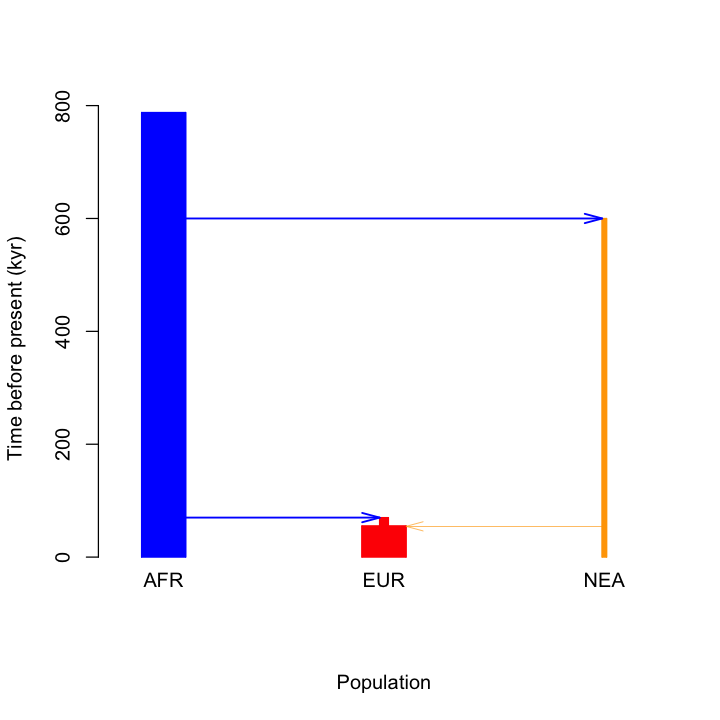

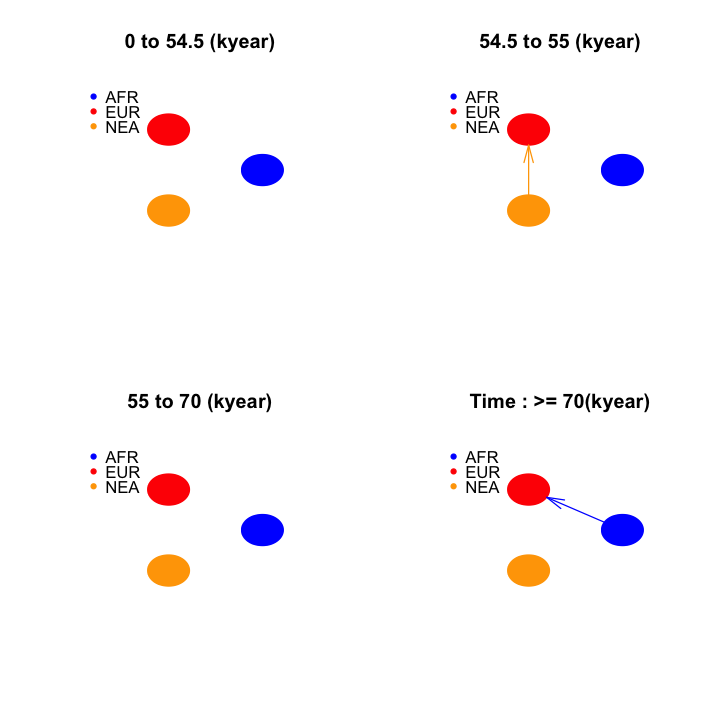

In [9]:
options(repr.plot.width=6, repr.plot.height=6)

PlotMS(scrm_cmd, type="scrm",
       pops=c("AFR", "EUR", "NEA"),
       col.pop=c("blue", "red", "orange"),
       time.scale="kyear", N4=4*Ne0,
       demo.out=TRUE) -> plot_out
PlotMMig(demograph_out=plot_out$demograph_out, mig_par=plot_out$mig_par)

### Run the simulation and extract the matrix with simulated haplotypes

In [10]:
sim_res <- scrm(scrm_cmd)

In [11]:
# generate column names for the output df
col_names <- c(paste0("nea_", 1:n_nea),
               ages$name,
               paste0("afr_", 1:n_afr),
               paste0("eur_", 1:n_eur))

In [12]:
# extract matrices with simulated haplotypes and set the column names
all_sites <- map(sim_res$seg_sites, ~ .x %>% t %>% as_tibble %>% setNames(col_names)) %>% bind_rows

In [13]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6110145,326.4,28988804,1548.2,36236006,1935.3
Vcells,3687974061,28137.1,9082321214,69292.7,5534646017,42226.0


### "Design" the archaic admixture array
Keep only those sites that are nearly fixed in Africans, and fixed for a different allele in the Neanderthals (ignore the derived/ancestral state).

**To make testing easier, I'm requiring the African allele to be fixed! This will be changed later.**

In [14]:
# the lowest frequency of an allele allowed in the African population
afr_cutoff <- 1.0

In [15]:
calc_freq <- function(df, pop, n) {
    all_sites[str_detect(col_names, pop)] %>% rowSums / n
}

In [16]:
afr_freq <- calc_freq(all_sites, "afr", n_afr)
nea_freq <- calc_freq(all_sites, "nea", n_nea)

In [17]:
array_sites <- filter(all_sites,
                     (afr_freq == 0 | afr_freq >= afr_cutoff) &
                     (nea_freq == 0 | nea_freq == 1) &
                     (abs(afr_freq - nea_freq) > 0.5))

What are the observed site patterns in Africans and Neanderthals? There should be only two:

In [18]:
distinct(select(array_sites, -starts_with("eur"), -starts_with("emh")))

nea_1,nea_2,nea_3,nea_4,afr_1,afr_2,afr_3,afr_4,afr_5,afr_6,⋯,afr_191,afr_192,afr_193,afr_194,afr_195,afr_196,afr_197,afr_198,afr_199,afr_200
1,1,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


### Detect Neanderthal introgressed alleles in simulated Europeans

Detect all Neanderthal alleles in the non-African population (TRUE/FALSE at each site converted to integers - 1 is Nea-like allele, 0 is an African-like MH allele):

In [19]:
introgressed_snps <- map_df(select(array_sites, starts_with("eur"), starts_with("emh")),
                            ~ as.integer(. == array_sites$nea_1))

What are the leves of Nea. ancestry in non-African haplotypes?

In [20]:
nea_ancestry <- function(df, pop) {
    select(df, starts_with(pop)) %>% summarise_all(mean)
}

In [21]:
nea_ancestry(introgressed_snps, "eur")

eur_1,eur_2,eur_3,eur_4,eur_5,eur_6,eur_7,eur_8,eur_9,eur_10,⋯,eur_91,eur_92,eur_93,eur_94,eur_95,eur_96,eur_97,eur_98,eur_99,eur_100
0.0242641,0.02368463,0.02495871,0.02455856,0.02435659,0.02309006,0.02428486,0.02542304,0.02576091,0.02481903,⋯,0.02518333,0.02537963,0.02424711,0.02437547,0.02351098,0.02437358,0.02454912,0.02346757,0.02480393,0.02356949


### Check the SFS of introgressed alleles in present-day Europeans

In [22]:
(select(introgressed_snps, starts_with("eur"))  %>% rowSums / n_eur) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02426 0.01000 1.00000 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


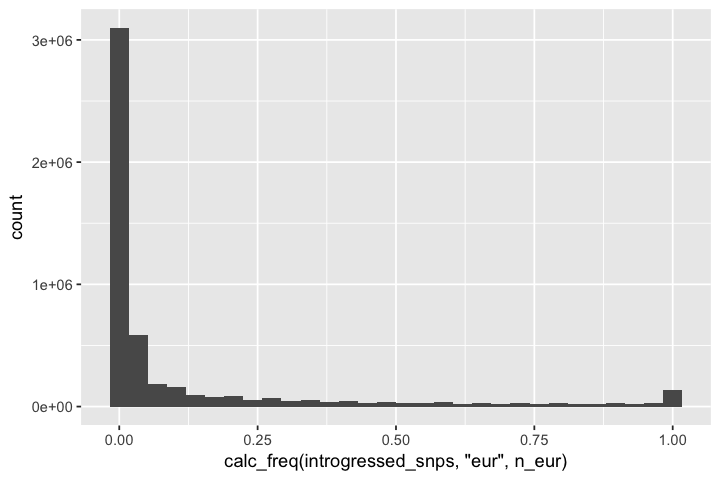

In [23]:
options(repr.plot.width=6, repr.plot.height=4)

qplot(calc_freq(introgressed_snps, "eur", n_eur))

### Plot the simulated Nea. ancestry over time

In [24]:
sim_nea <- bind_cols(
    nea_ancestry(introgressed_snps, "emh"),
    nea_ancestry(introgressed_snps, "eur")
) %>%
    gather(name, nea) %>%
    inner_join(ages)

Joining, by = "name"


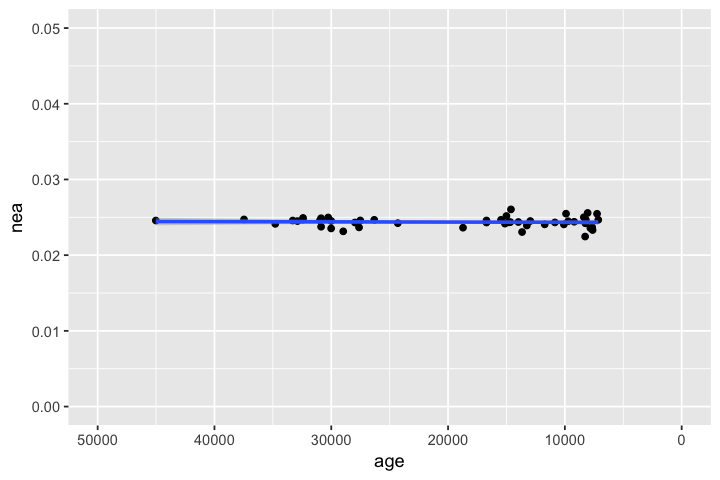

In [25]:
ggplot(sim_nea, aes(age, nea)) + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")